# Import files

In [ ]:
from Strats.PairTradingStrat import *
from PnL_Metrics.PortfolioMetrics import *
from PnL_Metrics.WRC import *

import warnings

warnings.filterwarnings("ignore")

# Run Strats

In [2]:
# Get all available tickers
response = requests.get(f"{BASE_URL}/ticker/price")
data = response.json()
BTC_pairs = [i["symbol"] for i in data if "BTC" in i["symbol"]]


In [11]:
coint_pairs = get_coint_pairs(BTC_pairs, interval = '5m', start_date="2024-01-01", end_date="2024-01-31")
len(coint_pairs)

100%|██████████| 524/524 [16:11<00:00,  1.85s/it]


62

In [177]:
test_pairs = coint_pairs[:4]
test_pairs = ['ETHUSDT']
print(test_pairs)

symbol_manager = BinanceSymbolManager()
# Add symbols
for t in test_pairs:
    print(symbol_manager.add_symbol(t))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
pair_portfolio = price_fetcher.get_grp_historical_ohlcv(
        interval="5m",
        start_date="2024-11-01",
        end_date="2024-12-31"
    )

pair_portfolio

['ETHUSDT']
'ETHUSDT' added successfully.


,timestamp,ETHUSDT
0,2024-11-01 00:00:00,2522.94
1,2024-11-01 00:05:00,2524.90
2,2024-11-01 00:10:00,2527.19
3,2024-11-01 00:15:00,2527.86
4,2024-11-01 00:20:00,2525.93
...,...,...
17276,2024-12-30 23:40:00,3363.79
17277,2024-12-30 23:45:00,3364.12
17278,2024-12-30 23:50:00,3362.51
17279,2024-12-30 23:55:00,3361.84


In [ ]:
def hurst_exponent(ts: pd.Series, max_lags: int = 50) -> float:
    """
    Calculate the Hurst Exponent of a time series.
        
    Args:
        time_series (pd.Series): Input time series (e.g., stock prices, spreads).
        max_lags (int): Maximum number of lags to compute rescaled range (R/S).
        
    Returns:
        float: Hurst Exponent value.
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0


class pair_trading:
    def __init__(self, df, weights):
        self.df = df
        self.tickers = df.columns.tolist()[1:]
        self.weights = weights


    def generate_signals(self, lookback, execute_threshold, close_threshold):
        # Calculate the rolling mean with a window size of lookback
        for t in self.tickers:
            self.df[t+'_rolling_mean'] = self.df[t].rolling(window=lookback).mean()
            self.df[t+'_rolling_std'] = self.df[t].rolling(window=lookback).std()
            self.df[t+'_z_scores'] = (self.df[t] - self.df[t+'_rolling_mean']) / self.df[t+'_rolling_std']
            is_mean_revert = []
            for i in range(lookback, len(self.df)):
                if hurst_exponent(self.df[t][i-lookback:i].values) < 0.5:
                    is_mean_revert += [1]
                else:
                    is_mean_revert += [0]
                
            self.df[t+'_is_mean_revert'] = [0] * (len(self.df) - len(is_mean_revert)) + is_mean_revert
            self.df[t+"_is_mean_revert"] = self.df[t+"_is_mean_revert"].fillna(0)

            self.df[t+'_signal'] = np.where((self.df[t+'_z_scores'] > execute_threshold) | (self.df[t+'_z_scores'] < -execute_threshold), 1, 0)
            self.df[t+'_signal'] = np.where(self.df[t+'_is_mean_revert'] != 1, 0, self.df[t+'_signal'])
        

            self.df[t+'_exit_signal'] = np.where((self.df[t+'_z_scores'] > -close_threshold) & (self.df[t+'_z_scores'] < close_threshold), 1, 0)
            self.df[t+'_exit_signal'] = np.where(self.df[t+'_exit_signal'] != 1, 1, self.df[t+'_exit_signal'])

        return self.df
    

    def backtest(self, ticker, test_start_date, stoploss = 0.1, drawdown_duration = 100): #have not account for capital
        trades = self.df[self.df['timestamp'] >= test_start_date].copy().reset_index(drop=True)
        # PnL variables - one set per security
        position = 0
        pnlUnrealized = 0
        pnlRealized = 0

        avg_short_price = 0
        short_pos = 0
        avg_long_price = 0
        long_pos = 0
        closed_pos = 0

        positions = []
        pnlUnrealized_list = []
        pnlRealized_list = []
        daily_pnl = []
        daily_pnl_pct = []

        # for each trade
        for i in range(0, len(trades)):
            qty = trades[ticker+'_signal'][i]
            price = trades[ticker][i]
            exit_signal = trades[ticker+'_exit_signal'][i]

            if exit_signal == 1:
                if position != 0:
                    qty = -position #close position
            elif daily_pnl_pct[-1] < -stoploss: 
                if position != 0:
                    qty = -position #close position
            elif (np.array(daily_pnl_pct[-drawdown_duration:]) <= 0).sum() == drawdown_duration:
                if position != 0:
                     qty = -position #close position


            if qty < 0:
                avg_short_price = (avg_short_price * short_pos + price * qty) / (short_pos + qty)
                short_pos += qty
            elif qty > 0:
                avg_long_price = (avg_long_price * long_pos + price * qty) / (long_pos + qty)
                long_pos += qty

            if i > 0:
                if (qty * position) < 0:
                    closed_pos = min(abs(qty), abs(position))
                else:
                    closed_pos = 0
                short_pos += closed_pos
                long_pos -= closed_pos

                if (position+qty) < 0:
                    pnlUnrealized = (avg_short_price - price) * -(position+qty)
                else:
                    pnlUnrealized = (avg_long_price - price) * (position+qty)
                # print(closed_pos)

            position += qty
            pnlRealized += (avg_short_price - avg_long_price) * closed_pos
            daily_pnl += [(avg_short_price - avg_long_price) * closed_pos + pnlUnrealized]

            positions += [position]
            pnlUnrealized_list += [pnlUnrealized]
            pnlRealized_list += [pnlRealized]
            try:
                daily_pnl_pct += [((pnlRealized+pnlUnrealized) - (pnlUnrealized_list[-2] + pnlRealized_list[-2]))/abs(pnlUnrealized_list[-2] + pnlRealized_list[-2]+1e-10)]
            except:
                daily_pnl_pct += [np.nan]

            if short_pos == 0:
                avg_short_price = 0
            if long_pos == 0:
                avg_long_price = 0

        pnl_df = trades[["timestamp", ticker, ticker+"_signal"]].copy()
        pnl_df.columns = ["Date", "Price", "Signal"]
        pnl_df["Positions"] = positions
        pnl_df["Realized_PnL"] = pnlRealized_list
        pnl_df["Unrealized_PnL"] = pnlUnrealized_list
        pnl_df["Daily_PnL"] = daily_pnl
        pnl_df["Daily_PnL_Pct"] = daily_pnl_pct
        pnl_df["PnL_Total"] = pnl_df["Realized_PnL"] + pnl_df["Unrealized_PnL"]

        return pnl_df

    def computePortfolioPnL(self, test_start_date, stoploss=0.1):
        portfolioPnL = pd.DataFrame()
        for ind, t in enumerate(self.tickers):
            pnl_df = self.backtest(t, test_start_date, stoploss)
            portfolioPnL[t+"_daily_pnl"] = pnl_df["Daily_PnL"]
            portfolioPnL[t+"_daily_pnl_pct"] = pnl_df["Daily_PnL_Pct"]
            if ind > 0:
                portfolioPnL["total_daily_pnl"] = portfolioPnL["total_daily_pnl"] + portfolioPnL[t+"_daily_pnl"] * self.weights[ind]
                portfolioPnL["total_daily_pnl_pct"] = portfolioPnL["total_daily_pnl_pct"] + portfolioPnL[t+"_daily_pnl_pct"] * self.weights[ind]
                portfolioPnL["total_pnl"] = portfolioPnL["total_pnl"] + pnl_df["PnL_Total"] * self.weights[ind]
            else:
                portfolioPnL["total_daily_pnl"] = portfolioPnL[t+"_daily_pnl"] * self.weights[ind]
                portfolioPnL["total_daily_pnl_pct"] = portfolioPnL[t+"_daily_pnl_pct"] * self.weights[ind]
                portfolioPnL["total_pnl"] = pnl_df["PnL_Total"] * self.weights[ind]

        portfolioPnL["timestamp"] = pnl_df["Date"]
        portfolioPnL = portfolioPnL[["timestamp", "total_daily_pnl", "total_daily_pnl_pct", "total_pnl"]]

        return portfolioPnL
    
    def plot_pnl(self, test_start_date):
        fig, axs = plt.subplots(len(self.tickers)+1,1, figsize=(15,9), sharex=True)

        for i, t in enumerate(self.tickers):
            pnl_df = self.backtest(t, test_start_date)
            axs[i].plot(pnl_df["Date"], pnl_df["PnL_Total"], label=f"{t}_PnL_Total")
            axs[i].set_ylabel("Accumulated PnL")
            axs[i].set_xlabel("Date")
            axs[i].legend()
            axs[i].grid(True)

        total_pnl_df = self.computePortfolioPnL(test_start_date)
        axs[len(self.tickers)].plot(total_pnl_df["timestamp"], total_pnl_df["total_pnl"], label="Portfolio")
        axs[len(self.tickers)].set_ylabel("Accumulated PnL")
        axs[len(self.tickers)].set_xlabel("Date")
        axs[len(self.tickers)].legend()
        axs[len(self.tickers)].grid(True)

        plt.show()

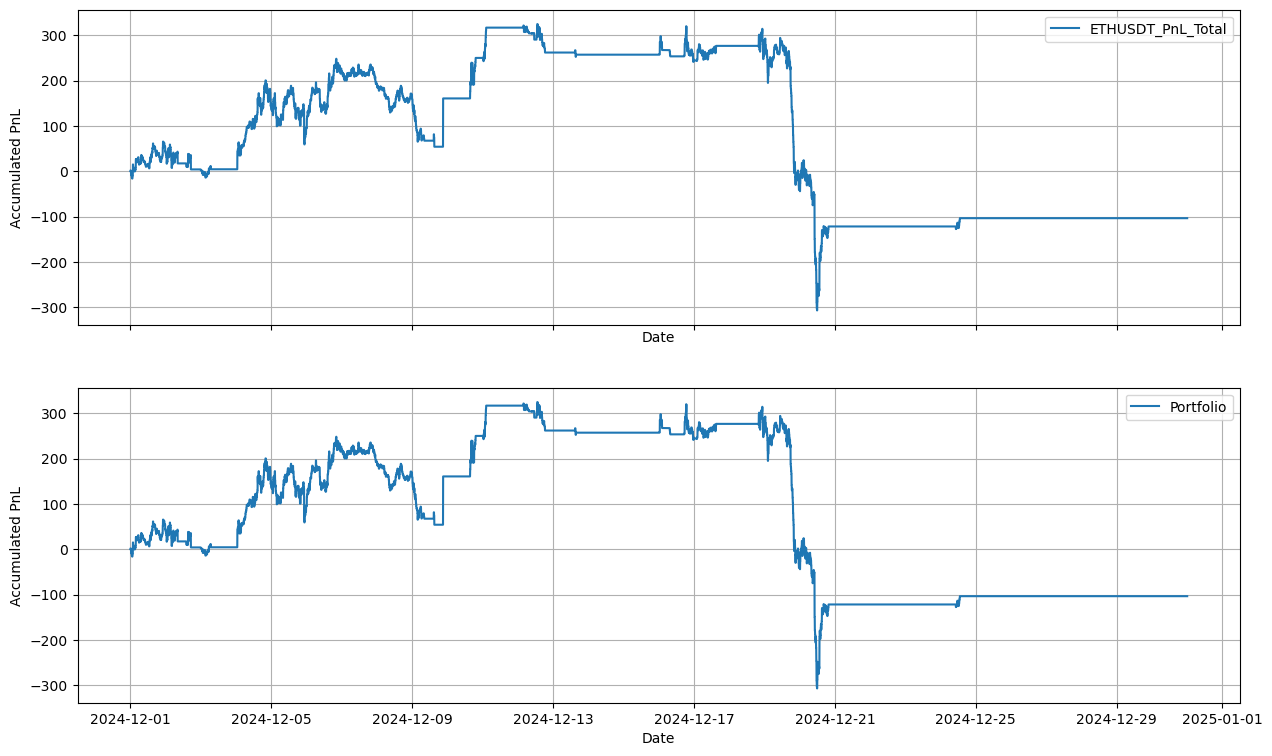

In [203]:
weights = np.array([1/len(test_pairs) for i in range(len(test_pairs))])
model = pair_trading(pair_portfolio.copy(), weights)
spread = model.generate_signals(lookback=3600, execute_threshold=1, close_threshold=0.5)
model.plot_pnl(test_start_date="2024-12-01")

In [204]:
pnl_df = model.computePortfolioPnL(test_start_date="2024-12-01", stoploss=1)
pnl_df

,timestamp,total_daily_pnl,total_daily_pnl_pct,total_pnl
0,2024-12-01 00:00:00,0.00,NaN,0.00
1,2024-12-01 00:05:00,1.67,1.670000e+10,1.67
2,2024-12-01 00:10:00,0.00,0.000000e+00,1.67
3,2024-12-01 00:15:00,-0.38,-2.275449e-01,1.29
4,2024-12-01 00:20:00,0.00,0.000000e+00,1.29
...,...,...,...,...
8636,2024-12-30 23:40:00,0.00,0.000000e+00,-103.70
8637,2024-12-30 23:45:00,0.00,0.000000e+00,-103.70
8638,2024-12-30 23:50:00,0.00,0.000000e+00,-103.70
8639,2024-12-30 23:55:00,0.00,0.000000e+00,-103.70


In [200]:
trial = model.backtest(test_start_date="2024-12-01", ticker="ETHUSDT", stoploss = 0.1, drawdown_duration = 5)
trial

,Date,Price,Signal,Positions,Realized_PnL,Unrealized_PnL,Daily_PnL,Daily_PnL_Pct,PnL_Total
0,2024-12-01 00:00:00,3713.32,1,1,0.00,0.0,0.00,NaN,0.00
1,2024-12-01 00:05:00,3714.99,1,0,1.67,-0.0,1.67,1.670000e+10,1.67
2,2024-12-01 00:10:00,3726.96,1,1,1.67,0.0,0.00,0.000000e+00,1.67
3,2024-12-01 00:15:00,3726.58,1,0,1.29,0.0,-0.38,-2.275449e-01,1.29
4,2024-12-01 00:20:00,3723.50,1,1,1.29,0.0,0.00,0.000000e+00,1.29
...,...,...,...,...,...,...,...,...,...
8636,2024-12-30 23:40:00,3363.79,0,0,-145.49,-0.0,0.00,0.000000e+00,-145.49
8637,2024-12-30 23:45:00,3364.12,0,0,-145.49,-0.0,0.00,0.000000e+00,-145.49
8638,2024-12-30 23:50:00,3362.51,0,0,-145.49,-0.0,0.00,0.000000e+00,-145.49
8639,2024-12-30 23:55:00,3361.84,0,0,-145.49,-0.0,0.00,0.000000e+00,-145.49


In [ ]:
price_fetcher = BinancePriceFetcher(test_pairs)
# Fetch pair historical price
pair_portfolio_momentum = pair_portfolio[pair_portfolio["timestamp"] >= "2024-12-01"].reset_index(drop=True)

weights = np.array([1/len(test_pairs) for i in test_pairs])  # Equal-weighted

# Initialize strategy
strategy = SimpleStrategy(
    tickers=test_pairs,
    weights=weights,
    data=pair_portfolio_momentum
)

print(pair_portfolio.shape)
# Get momentum strategy returns
momentum_returns = strategy.momentum_strategy(lookback=30, hold_period=10)

(17281, 3)


# Comparison

In [193]:
returns = pd.DataFrame()
returns["Momentum"] = momentum_returns
returns["Pair_Trade"] = pnl_df[("total_daily_pnl_pct")]

port_metrics = PortfolioMetrics(returns.dropna())
summary = port_metrics.summary(risk_free_rate=0)
print(summary)

            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Momentum             0.013197               0.032017      0.425498   
Pair_Trade                NaN               6.368205     -0.046344   

            Max Drawdown Duration  Max Drawdown  Calmar Ratio  Skewness  \
Momentum                     3863     -0.088115      0.149767 -0.022121   
Pair_Trade                   3863     -3.231075           NaN  2.127534   

               Kurtosis  VaR (5%)  CVaR (5%)  Tail Ratio  Omega Ratio  
Momentum       6.342766 -0.011469  -0.016728    0.941009     1.080001  
Pair_Trade  1204.274457 -0.011469  -0.192905    0.941009     0.939680  


In [108]:
wrc = WhiteRealityCheck(strategies=returns["Pair_Trade"], benchmark=returns["Momentum"])
wrc.run()
wrc.superior_strategies()

White Reality Check Results:
p-value: lower         0.1
consistent    0.1
upper         0.1
dtype: float64
Superior strategy indices:
[]


[]